# Modélisation de l'usure d'un moteur d'avion 

In [1]:
# Importation des packages 
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
from random import *

In [24]:
path_safran = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/db_anonymisee_23112020.csv'
safran=pd.read_csv(path_safran,sep=';')

## 1- Nettoyage de la base 

In [3]:
safran.head()

,Unnamed: 0,engine_serial_number,engine_family,engine_series,date,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,...,Config_B_rank,WW_indicator,WW_rank,config_A,config_B,var_env_1,var_env_2,var_env_3,var_env_4,var_env_5
0,1,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 06:29:58,"14,6994018817204",14,"0,88164595777172","-0,313549479463945","0,857777777777778",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,261068039892915","0,193871444563971","0,448626837816052",0.0,"0,601803253301208"
1,2,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 08:10:00,"15,2842741935484",15,"0,792029198534478","0,00633010844634316","0,794166666666667",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,0642022854971854","0,273855127894862","1,50084830667547",0.0,"-1,05696480756781"
2,3,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 09:55:00,"15,898185483871",16,"0,706729072821315","-0,286324152682434","0,736666666666667",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,292673075440896","0,193871444563971","0,764293278473876",0.0,"0,149411963973295"
3,4,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 11:36:53,"16,493874327957",17,"0,702077542200021","0,430173809670278","0,8025",...,0.0,0,0.0,Config_A_1,Config_B_1,"0,0700560728074165","0,273855127894862","1,50084830667547",0.0,"-1,05696480756781"
4,5,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 04:28:40,"22,4095430107527",18,"0,645940989733346","0,299419735518525","0,8175",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,463184861568854","0,193871444563971","0,448626837816052",0.0,"0,601803253301208"


In [4]:
safran.shape

(2913834, 25)

Nous avons sous la main une base de données d'environ 3 millions de lignes, chacune est représenté par 25 variables. 

In [5]:
safran['engine_serial_number'].nunique()

1397

### 1-1. Les formats 

In [6]:
safran.dtypes

Unnamed: 0                int64
engine_serial_number     object
engine_family            object
engine_series            object
date                     object
cycles                   object
cycles_counter            int64
egt_margin               object
var_mot_1                object
flight_leg_hours         object
event_rank                int64
egt_slope                object
SV_indicator              int64
SV_rank                 float64
Config_B_indicator        int64
Config_B_rank           float64
WW_indicator              int64
WW_rank                 float64
config_A                 object
config_B                 object
var_env_1                object
var_env_2                object
var_env_3                object
var_env_4               float64
var_env_5                object
dtype: object

Certaines variables ont un format qui ne leur correspond pas, réglons cela : 

In [7]:
# Transformation du format de la variable date en datetime 
safran['date'] = pd.to_datetime(safran['date'], format="%Y/%m/%d %H:%M:%S")

In [8]:
# Transformation du format des variable egt_margin, cycles, var_mot_1,flight_leg_hours et les variables environnementales 
# continues  en float (sauf pour les valeurs 'nan')
def replace_value (x):
    try: 
        return x.replace(",", ".")
    except AttributeError:
        return np.NaN
safran['egt_margin'] = safran['egt_margin'].map(replace_value)
safran['egt_margin']=pd.to_numeric(safran['egt_margin'])
safran['cycles'] = safran['cycles'].map(replace_value)
safran['cycles']=pd.to_numeric(safran['cycles'])
safran['var_mot_1']=safran['var_mot_1'].map(replace_value)
safran['var_mot_1']=pd.to_numeric(safran['var_mot_1'])
safran['flight_leg_hours']=safran['flight_leg_hours'].map(replace_value)
safran['flight_leg_hours']=pd.to_numeric(safran['flight_leg_hours'])
safran['egt_slope']=safran['egt_slope'].map(replace_value)
safran['egt_slope']=pd.to_numeric(safran['egt_slope'])
safran['var_env_1']=safran['var_env_1'].map(replace_value)
safran['var_env_1']=pd.to_numeric(safran['var_env_1'])
safran['var_env_2']=safran['var_env_2'].map(replace_value)
safran['var_env_2']=pd.to_numeric(safran['var_env_2'])
safran['var_env_3']=safran['var_env_3'].map(replace_value)
safran['var_env_3']=pd.to_numeric(safran['var_env_3'])
safran['var_env_5']=safran['var_env_5'].map(replace_value)
safran['var_env_5']=pd.to_numeric(safran['var_env_5'])

In [9]:
safran.dtypes

Unnamed: 0                       int64
engine_serial_number            object
engine_family                   object
engine_series                   object
date                    datetime64[ns]
cycles                         float64
cycles_counter                   int64
egt_margin                     float64
var_mot_1                      float64
flight_leg_hours               float64
event_rank                       int64
egt_slope                      float64
SV_indicator                     int64
SV_rank                        float64
Config_B_indicator               int64
Config_B_rank                  float64
WW_indicator                     int64
WW_rank                        float64
config_A                        object
config_B                        object
var_env_1                      float64
var_env_2                      float64
var_env_3                      float64
var_env_4                      float64
var_env_5                      float64
dtype: object

### 1-2. Les valeurs manquantes 

In [10]:
safran.isnull().sum()

Unnamed: 0                   0
engine_serial_number         0
engine_family                0
engine_series                0
date                         0
cycles                       0
cycles_counter               0
egt_margin              992605
var_mot_1               992607
flight_leg_hours        477302
event_rank                   0
egt_slope                90397
SV_indicator                 0
SV_rank                 992605
Config_B_indicator           0
Config_B_rank           992605
WW_indicator                 0
WW_rank                 992605
config_A                     0
config_B                     0
var_env_1               451389
var_env_2               258150
var_env_3               625419
var_env_4               622175
var_env_5               625530
dtype: int64

In [11]:
safran.head(20)

,Unnamed: 0,engine_serial_number,engine_family,engine_series,date,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,...,Config_B_rank,WW_indicator,WW_rank,config_A,config_B,var_env_1,var_env_2,var_env_3,var_env_4,var_env_5
0,1,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 06:29:58,14.699402,14,0.881646,-0.313549,0.857778,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.261068,0.193871,0.448627,0.0,0.601803
1,2,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 08:10:00,15.284274,15,0.792029,0.006330,0.794167,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.064202,0.273855,1.500848,0.0,-1.056965
2,3,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 09:55:00,15.898185,16,0.706729,-0.286324,0.736667,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.292673,0.193871,0.764293,0.0,0.149412
3,4,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 11:36:53,16.493874,17,0.702078,0.430174,0.802500,...,0.0,0,0.0,Config_A_1,Config_B_1,0.070056,0.273855,1.500848,0.0,-1.056965
4,5,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 04:28:40,22.409543,18,0.645941,0.299420,0.817500,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.463185,0.193871,0.448627,0.0,0.601803
5,6,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 06:06:47,22.983209,19,0.784083,0.317381,0.857778,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.366676,0.273855,1.079960,0.0,-0.001385
6,7,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 09:21:07,24.119432,20,0.794602,0.302614,0.689722,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.477086,0.193871,0.974738,0.0,-0.805636
7,8,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 10:59:07,24.692416,21,0.650154,0.635736,0.651944,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.328584,0.234348,1.606070,0.0,-2.464404
8,9,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 14:27:15,25.909325,22,0.620501,0.351562,0.995000,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.214059,0.193871,0.869515,0.0,-0.805636
9,10,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 16:21:55,26.579755,23,0.932190,-0.246205,1.357778,...,0.0,0,0.0,Config_A_1,Config_B_1,-0.109072,0.503899,0.974738,0.0,0.199678


De nombreuses variables ont un nombre important de valeurs manquantes.

#### 1-2.1 Traitement des valeurs manquantes pour egt_margin

In [12]:
print(' Part des valeurs manquantes pour egt_margin : ', int(safran['egt_margin'].isnull().sum() /safran['egt_margin'].size * 100),'%')

 Part des valeurs manquantes pour egt_margin :  34 %


egt_margin est la variable que nous cherchons à expliquer. Pour pouvoir entrainer et tester notre futur modèle il nous faudra l'ensemble des données. Il faut donc traiter les valeurs manquantes, qui représentent une part importante du dataframe pour cette varible (34%).  

Pour cela nous proposons d'appliquer l'interpolation des données manquantes. 

Nous traitons séparemment les différents avions :

In [13]:
print('Taille de la base complete :', safran.shape[0], '\n', 'Nombre d\'avions : ', safran['engine_serial_number'].nunique())

Taille de la base complete : 2913834 
 Nombre d'avions :  1397


In [14]:
safran.groupby(by=['engine_serial_number']).size().describe()

count    1397.000000
mean     2085.779528
std      1504.761387
min         1.000000
25%       791.000000
50%      1824.000000
75%      2973.000000
max      7919.000000
dtype: float64

En moyenne, un avion est représenté par 2 000 vols (écart type de 1 500). 

Au minimum un avion est représenté par 1 vol. Dans notre base, le maximum est de 7 919 vols pour un avion. 

Effectuons quelques analyses exploratoires pour un avion en particulier : Celui représenté par le moteur ESN_1 :

In [26]:
Avion1= safran[safran['engine_serial_number']=='ESN_1']
Avion1

,Unnamed: 0,engine_serial_number,engine_family,engine_series,date,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,...,Config_B_rank,WW_indicator,WW_rank,config_A,config_B,var_env_1,var_env_2,var_env_3,var_env_4,var_env_5
0,1,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 06:29:58,"14,6994018817204",14,"0,88164595777172","-0,313549479463945","0,857777777777778",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,261068039892915","0,193871444563971","0,448626837816052",0.0,"0,601803253301208"
1,2,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 08:10:00,"15,2842741935484",15,"0,792029198534478","0,00633010844634316","0,794166666666667",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,0642022854971854","0,273855127894862","1,50084830667547",0.0,"-1,05696480756781"
2,3,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 09:55:00,"15,898185483871",16,"0,706729072821315","-0,286324152682434","0,736666666666667",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,292673075440896","0,193871444563971","0,764293278473876",0.0,"0,149411963973295"
3,4,ESN_1,Engine_family_1,Engine_series_1,2019-04-29 11:36:53,"16,493874327957",17,"0,702077542200021","0,430173809670278","0,8025",...,0.0,0,0.0,Config_A_1,Config_B_1,"0,0700560728074165","0,273855127894862","1,50084830667547",0.0,"-1,05696480756781"
4,5,ESN_1,Engine_family_1,Engine_series_1,2019-04-30 04:28:40,"22,4095430107527",18,"0,645940989733346","0,299419735518525","0,8175",...,0.0,0,0.0,Config_A_1,Config_B_1,"-0,463184861568854","0,193871444563971","0,448626837816052",0.0,"0,601803253301208"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,5903,ESN_1,Engine_family_1,Engine_series_1,2022-02-19 05:33:00,"5862,76149193548",5916,"1,19504426701622","-0,515554015147536","1,06944444444444",...,6.0,0,6.0,Config_A_1,Config_B_4,"-0,457841205150334","1,5360122031815","-0,0774838966136551",0.0,"0,400740458044358"
5903,5904,ESN_1,Engine_family_1,Engine_series_1,2022-02-19 08:01:36,"5863,23086021505",5917,"1,20468681298749","-0,667086565934111","1,22055555555556",...,6.0,0,6.0,Config_A_1,Config_B_4,"-0,578923882649018","1,44436556241136","0,448626837816052",0.0,"-0,755370614682532"
5904,5905,ESN_1,Engine_family_1,Engine_series_1,2022-02-19 10:22:31,"5863,67595990143",5918,"1,10694371997938","-0,630176285564247","1,59694444444444",...,6.0,0,6.0,Config_A_1,Config_B_4,"-0,50388942522577","1,5360122031815","0,34340469093011",0.0,"-0,755370614682532"
5905,5906,ESN_1,Engine_family_1,Engine_series_1,2022-02-19 13:14:25,"5864,21892361111",5919,"1,00689435909437","0,586222312793476","1,73916666666667",...,6.0,0,6.0,Config_A_1,Config_B_4,"-0,558963999118755","1,50766272407743","0,553848984701993",0.0,"-0,90616771112517"


In [27]:
Avion1['egt_margin'].isnull().sum()

1880

Testons l'interpolation pour le premier avion 

In [28]:
# On commence par indexer le DataFrame par les dates 
Avion1.index = Avion1['date']
del Avion1['date']

In [29]:
# Méthode "Time" car importance du temps
Avion1 = Avion1.assign(InterpolateTime=Avion1.egt_margin.interpolate(method='time'))

<AxesSubplot:xlabel='date'>

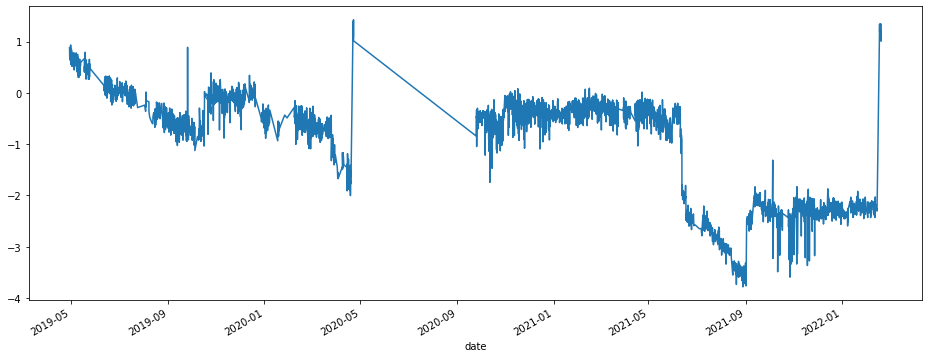

In [19]:
Avion1['InterpolateTime'].plot(figsize = (16,6))

<AxesSubplot:xlabel='date'>

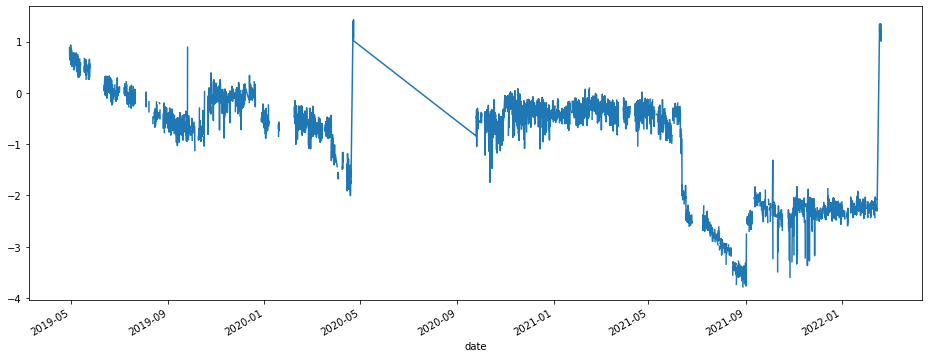

In [20]:
Avion1['egt_margin'].plot(figsize = (16,6))

On teste sur la base complète :

In [21]:
safran_test = safran.copy()
safran_test.index = safran_test['date']
del safran_test['date']

In [22]:
safran_test.groupby('engine_serial_number')
safran_test=safran_test.assign(InterpolateTime=safran_test.egt_margin.interpolate(method='time'))

In [23]:
safran_test.InterpolateTime.isnull().sum()

0

<AxesSubplot:xlabel='date'>

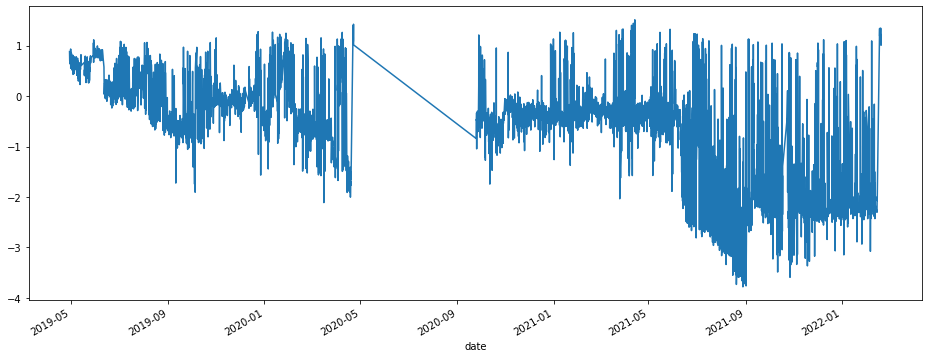

In [24]:
safran_test[safran_test['engine_serial_number']=='ESN_1']['InterpolateTime'].plot(figsize = (16,6))

Ressemble pas ... 

Testons un par un pour limiter le bruit :

In [25]:
# Cette cellule est relativement longue ( de l'ordre de 10-15 minutes)
# On divise en deux pour limiter le temps de calcul

series = safran['engine_serial_number'].unique()
series_1,series_2 = series[0: int(len(series)/2)], series[int(len(series)/2):int(len(series))]

calage_1 = series_1[0]
calage_2 = series_2[0]

Avion_1= safran[safran['engine_serial_number']==calage_1]
Avion_2= safran[safran['engine_serial_number']==calage_2]
series_1=np.delete(series_1,0)
series_2=np.delete(series_2,0)

Avion_1.index = Avion_1['date']
del Avion_1['date']
Avion_1 = Avion_1.assign(Interpolate_egt_margin=Avion_1.egt_margin.interpolate(method='time'))

Avion_2.index = Avion_2['date']
del Avion_2['date']
Avion_2 = Avion_2.assign(Interpolate_egt_margin=Avion_2.egt_margin.interpolate(method='time'))

for i in series_1 : 
    avion_i= safran[safran['engine_serial_number']==i]
    avion_i.index = avion_i['date']
    del avion_i['date']
    avion= avion_i.assign(Interpolate_egt_margin=avion_i.egt_margin.interpolate(method='time'))
    Avion_1 = pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")

for i in series_2 : 
    avion_i= safran[safran['engine_serial_number']==i]
    avion_i.index = avion_i['date']
    del avion_i['date']
    avion= avion_i.assign(Interpolate_egt_margin=avion_i.egt_margin.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

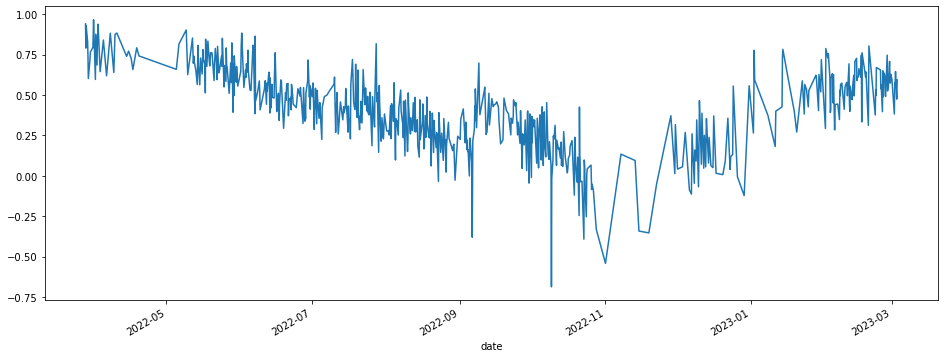

In [26]:
# Affichage de l'évolution de la marge egt au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_egt_margin'].plot(figsize = (16,6))

In [27]:
# Verifions qu'il n'y a plus de valeur manquante pour la marge egt 
Avions.Interpolate_egt_margin.isnull().sum()

0

#### 1-2.2 Traitement des valeurs manquantes pour var_mot_1

In [28]:
# Création d'une copie de Avions en cas d'erreur 
Test= Avions.copy()

In [29]:
Test.var_mot_1.isnull().sum() # Variable d'utilisation du moteur 

992607

In [30]:
print(' Le nombre de valeurs manquantes pour la variable var_moteur est de ', Test.var_mot_1.isnull().sum()/Test.var_mot_1.shape[0]*100, '%')

 Le nombre de valeurs manquantes pour la variable var_moteur est de  34.06532424290471 %


<AxesSubplot:xlabel='date'>

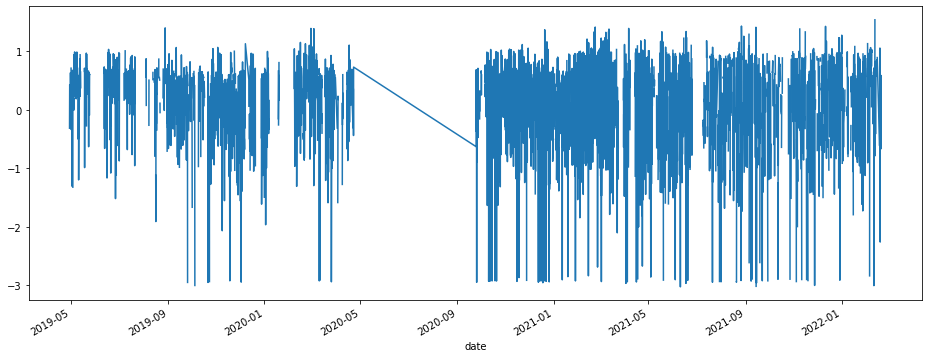

In [31]:
# Exemple pour l'avion représenté par le moteur ESN_1
Avion1['var_mot_1'].plot(figsize = (16,6))

De la même façon que pour la variable egt_margin on effectue une interpolation temporelle. 

In [32]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_mot_1=Avion_1.var_mot_1.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_mot_1=Avion_2.var_mot_1.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_mot_1=avion_i.var_mot_1.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_mot_1=avion_i.var_mot_1.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [33]:
Avions

,Unnamed: 0,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,...,WW_rank,config_A,config_B,var_env_1,var_env_2,var_env_3,var_env_4,var_env_5,Interpolate_egt_margin,Interpolate_var_mot_1
date,,,,,,,,,,,,,,,,,,,,,
2019-04-29 06:29:58,1,ESN_1,Engine_family_1,Engine_series_1,14.699402,14,0.881646,-0.313549,0.857778,0,...,0.0,Config_A_1,Config_B_1,-0.261068,0.193871,0.448627,0.0,0.601803,0.881646,-0.313549
2019-04-29 08:10:00,2,ESN_1,Engine_family_1,Engine_series_1,15.284274,15,0.792029,0.006330,0.794167,0,...,0.0,Config_A_1,Config_B_1,-0.064202,0.273855,1.500848,0.0,-1.056965,0.792029,0.006330
2019-04-29 09:55:00,3,ESN_1,Engine_family_1,Engine_series_1,15.898185,16,0.706729,-0.286324,0.736667,0,...,0.0,Config_A_1,Config_B_1,-0.292673,0.193871,0.764293,0.0,0.149412,0.706729,-0.286324
2019-04-29 11:36:53,4,ESN_1,Engine_family_1,Engine_series_1,16.493874,17,0.702078,0.430174,0.802500,0,...,0.0,Config_A_1,Config_B_1,0.070056,0.273855,1.500848,0.0,-1.056965,0.702078,0.430174
2019-04-30 04:28:40,5,ESN_1,Engine_family_1,Engine_series_1,22.409543,18,0.645941,0.299420,0.817500,0,...,0.0,Config_A_1,Config_B_1,-0.463185,0.193871,0.448627,0.0,0.601803,0.645941,0.299420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01 17:28:50,2913830,ESN_1397,Engine_family_1,Engine_series_1,102.886000,130,0.899325,-0.081256,NaN,0,...,0.0,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.899325,-0.081256
2023-03-01 21:07:27,2913831,ESN_1397,Engine_family_1,Engine_series_1,103.042800,131,0.925950,0.694209,NaN,0,...,0.0,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.925950,0.694209
2023-03-02 12:02:07,2913832,ESN_1397,Engine_family_1,Engine_series_1,103.684900,132,0.970859,0.266096,NaN,0,...,0.0,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.970859,0.266096


In [34]:
# Affichage de l'évolution la variable d'utilisation du moteur  au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))

<AxesSubplot:xlabel='date'>

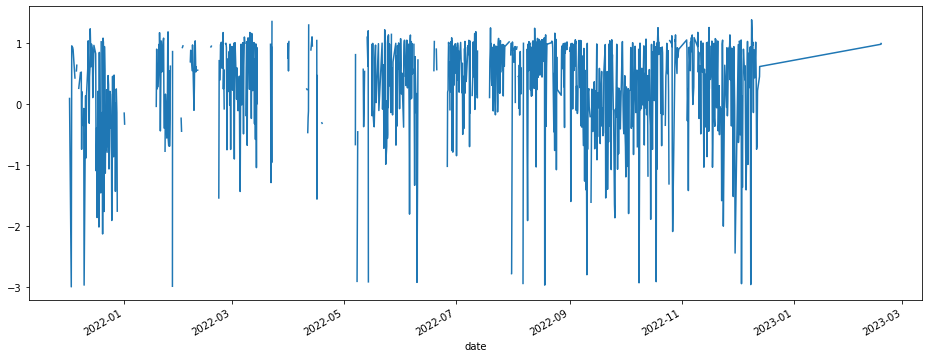

In [35]:
#Affichage avant traitement des valeurs manquantes :
Avions[Avions['engine_serial_number']==series[n]]['var_mot_1'].plot(figsize = (16,6))

<AxesSubplot:xlabel='date'>

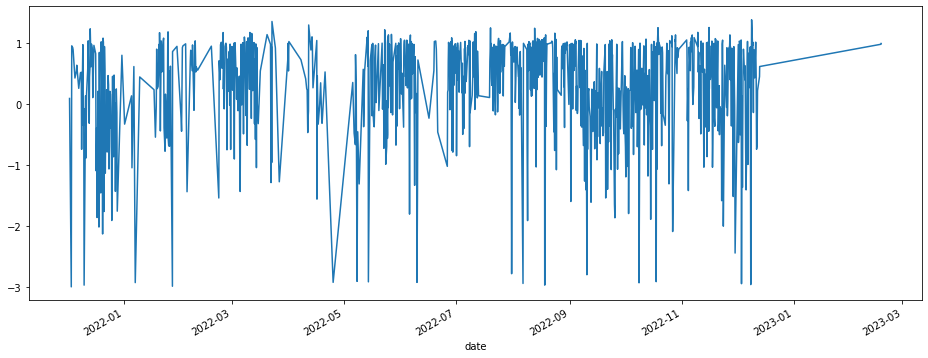

In [36]:
# Après traitement :
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_mot_1'].plot(figsize = (16,6))

In [37]:
Avions['Interpolate_var_mot_1'].isnull().sum()

0

#### 1-2.3 Traitement des valeurs manquantes pour flight_leg_hours

In [38]:
# Création d'une copie de Avions en cas d'erreur 
Test= Avions.copy()

In [39]:
Test.flight_leg_hours.isnull().sum() # Durée des vols

477302

<AxesSubplot:xlabel='date'>

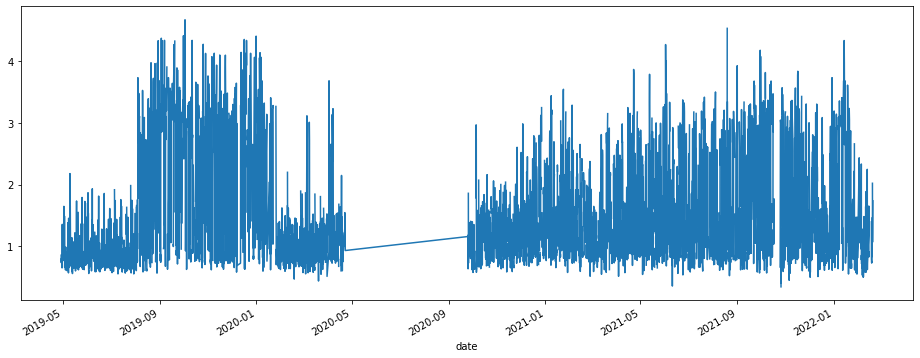

In [40]:
# Représentation pour le premier avion ESN_1
Avion1['flight_leg_hours'].plot(figsize = (16,6))

In [41]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_flight_leg_hours=Avion_1.flight_leg_hours.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_flight_leg_hours=Avion_2.flight_leg_hours.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.flight_leg_hours.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.flight_leg_hours.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

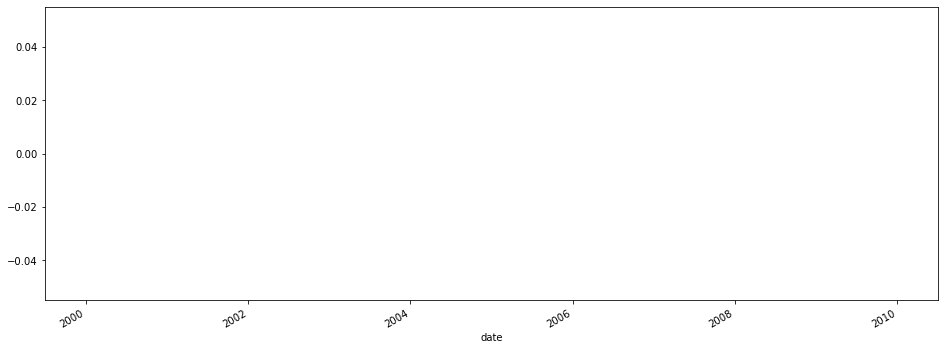

In [42]:
# Affichage de l'évolution la variable de durée de vols au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_flight_leg_hours'].plot(figsize = (16,6))

In [146]:
#Vérifions qu'il n'y a plus de valeur manquantes
Test['Interpolate_flight_leg_hours'].isnull().sum()

8496

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_flight_leg_hours=Avion_1.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_flight_leg_hours=Avion_2.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
#Vérifions qu'il n'y a plus de valeur manquantes
Test['Interpolate_flight_leg_hours'].isnull().sum()

In [147]:
Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].nunique()

67

Probleme pour 67 moteurs 

#### 1-2.4 Traitement des valeurs manquantes pour egt_slope 

In [49]:
Avions.egt_slope.isnull().sum() # Pente egt entre deux événements 

90397

Peut se calculer directement avec la norme EGT_margin sans passer par une interpolation directe de cette variable

In [50]:
# Récupération des avion présentant des valeurs manquante pour cette variable de pente :


In [51]:
Avions['engine_serial_number'].unique()

array(['ESN_1', 'ESN_2', 'ESN_3', ..., 'ESN_1395', 'ESN_1396', 'ESN_1397'],
      dtype=object)

In [52]:
vm=[]
for i in Avions['engine_serial_number'].unique():
    print (i)
    if Avions[Avions['engine_serial_number']==i].egt_slope.isnull().sum() != 0 :
        print('valeurs manquantes')
        vm.append(i)

ESN_1
ESN_2
ESN_3
valeurs manquantes
ESN_4
ESN_5
valeurs manquantes
ESN_6
valeurs manquantes
ESN_7
valeurs manquantes
ESN_8
valeurs manquantes
ESN_9
valeurs manquantes
ESN_10
valeurs manquantes
ESN_11
valeurs manquantes
ESN_12
valeurs manquantes
ESN_13
ESN_14
valeurs manquantes
ESN_15
ESN_16
ESN_17
ESN_18
valeurs manquantes
ESN_19
valeurs manquantes
ESN_20
valeurs manquantes
ESN_21
valeurs manquantes
ESN_22
ESN_23
ESN_24
valeurs manquantes
ESN_25
valeurs manquantes
ESN_26
valeurs manquantes
ESN_27
valeurs manquantes
ESN_28
ESN_29
valeurs manquantes
ESN_30
ESN_31
ESN_32
valeurs manquantes
ESN_33
valeurs manquantes
ESN_34
valeurs manquantes
ESN_35
valeurs manquantes
ESN_36
valeurs manquantes
ESN_37
valeurs manquantes
ESN_38
ESN_39
valeurs manquantes
ESN_40
valeurs manquantes
ESN_41
ESN_42
valeurs manquantes
ESN_43
valeurs manquantes
ESN_44
valeurs manquantes
ESN_45
valeurs manquantes
ESN_46
ESN_47
valeurs manquantes
ESN_48
ESN_49
valeurs manquantes
ESN_50
valeurs manquantes
ESN_51
valeur

In [53]:
len(vm)

406

In [54]:
avion3=Avions[Avions['engine_serial_number']=='ESN_3']

In [55]:
avion3[avion3['egt_slope'].isnull()==True]['event_rank'].unique()

array([ 7, 15, 19, 20], dtype=int64)

In [56]:
avion3[avion3['egt_slope'].isnull()==True]['Interpolate_egt_margin']

date
2020-05-22 00:27:36   -0.485703
2020-05-22 10:59:51   -0.165299
2020-05-22 22:11:53   -0.263515
2020-05-23 05:22:07   -0.599056
2020-05-23 06:36:27   -0.657029
                         ...   
2022-01-11 23:32:36   -1.091819
2022-01-12 10:00:12   -0.647060
2022-01-12 12:57:52   -0.561571
2022-01-12 15:12:08   -0.703390
2022-01-12 19:21:10   -0.734031
Name: Interpolate_egt_margin, Length: 97, dtype: float64

In [57]:
Avions[Avions['engine_serial_number']=='ESN_3']['event_rank'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

In [58]:
vm[0]

'ESN_3'

<AxesSubplot:xlabel='date'>

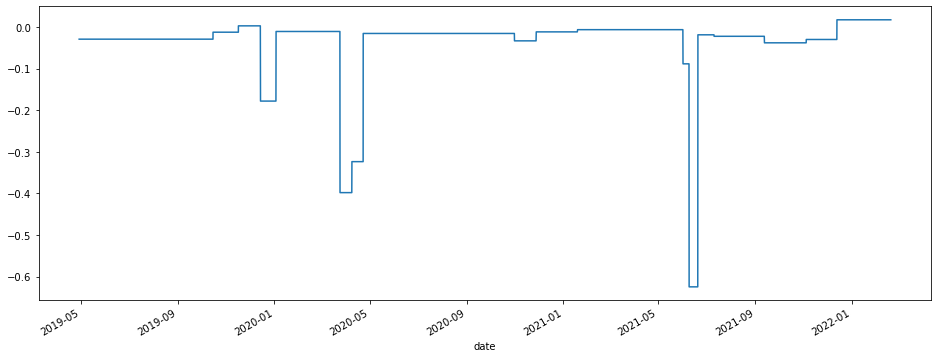

In [59]:
Avion1['egt_slope'].plot(figsize = (16,6))

<AxesSubplot:xlabel='date'>

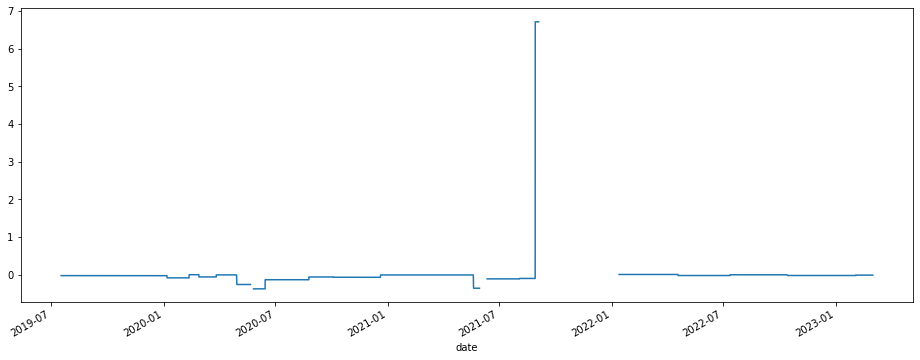

In [60]:
Avions[Avions['engine_serial_number']=='ESN_3']['egt_slope'].plot(figsize = (16,6))

In [61]:
avion3= Test[Test['engine_serial_number']=='ESN_5']
avion= avion3.assign(Interpolate_egt_slope=avion3.egt_slope.interpolate(method='time'))

<AxesSubplot:xlabel='date'>

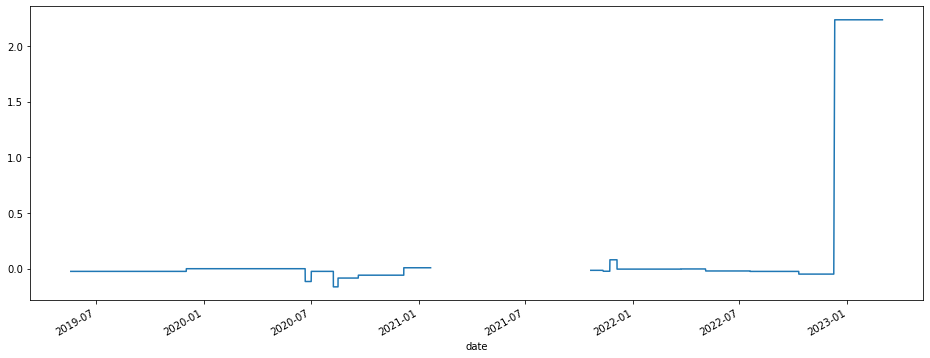

In [62]:
avion['egt_slope'].plot(figsize = (16,6))

<AxesSubplot:xlabel='date'>

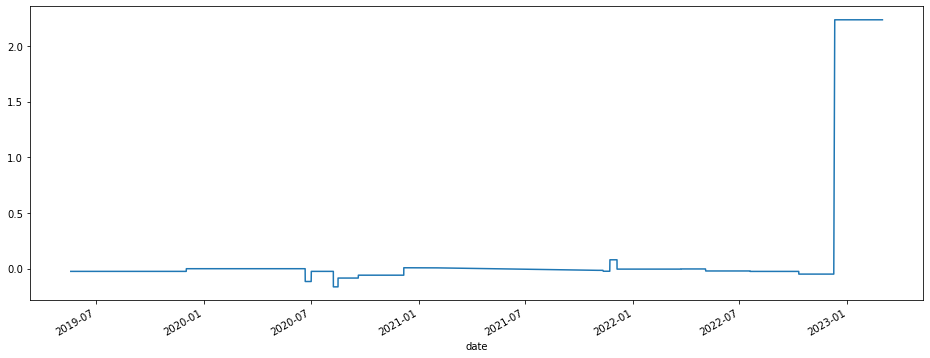

In [63]:
avion['Interpolate_egt_slope'].plot(figsize = (16,6))

In [64]:
avion3= Test[Test['engine_serial_number']=='ESN_5']
avion= avion3.assign(Interpolate_egt_slope=avion3.egt_slope.interpolate(method='linear'))

<AxesSubplot:xlabel='date'>

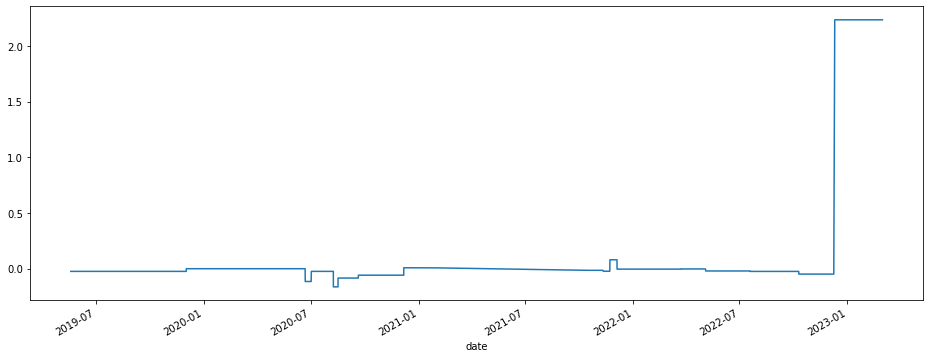

In [65]:
avion['Interpolate_egt_slope'].plot(figsize = (16,6))

#### 1-2.5 Traitement des valeurs manquantes pour SV_rank 

In [66]:
Avions.SV_rank.isnull().sum() # Nombre de fois passé en maintenance 

992605

<AxesSubplot:xlabel='date'>

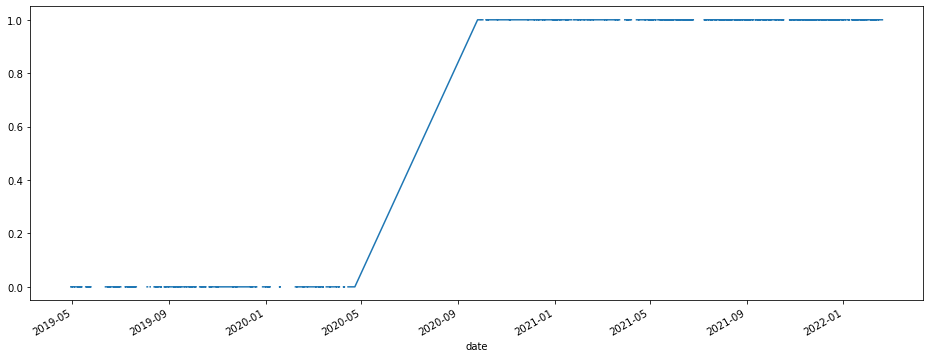

In [67]:
Avion1['SV_rank'].plot(figsize = (16,6))

Linéaire, on ne peut aller que de 1 en 1 : On utilise la méthode pad (se sert des valeurs existantes). 

In [68]:
Test=Avions.copy()
Test

,Unnamed: 0,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,...,config_A,config_B,var_env_1,var_env_2,var_env_3,var_env_4,var_env_5,Interpolate_egt_margin,Interpolate_var_mot_1,Interpolate_flight_leg_hours
date,,,,,,,,,,,,,,,,,,,,,
2019-04-29 06:29:58,1,ESN_1,Engine_family_1,Engine_series_1,14.699402,14,0.881646,-0.313549,0.857778,0,...,Config_A_1,Config_B_1,-0.261068,0.193871,0.448627,0.0,0.601803,0.881646,-0.313549,0.857778
2019-04-29 08:10:00,2,ESN_1,Engine_family_1,Engine_series_1,15.284274,15,0.792029,0.006330,0.794167,0,...,Config_A_1,Config_B_1,-0.064202,0.273855,1.500848,0.0,-1.056965,0.792029,0.006330,0.794167
2019-04-29 09:55:00,3,ESN_1,Engine_family_1,Engine_series_1,15.898185,16,0.706729,-0.286324,0.736667,0,...,Config_A_1,Config_B_1,-0.292673,0.193871,0.764293,0.0,0.149412,0.706729,-0.286324,0.736667
2019-04-29 11:36:53,4,ESN_1,Engine_family_1,Engine_series_1,16.493874,17,0.702078,0.430174,0.802500,0,...,Config_A_1,Config_B_1,0.070056,0.273855,1.500848,0.0,-1.056965,0.702078,0.430174,0.802500
2019-04-30 04:28:40,5,ESN_1,Engine_family_1,Engine_series_1,22.409543,18,0.645941,0.299420,0.817500,0,...,Config_A_1,Config_B_1,-0.463185,0.193871,0.448627,0.0,0.601803,0.645941,0.299420,0.817500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01 17:28:50,2913830,ESN_1397,Engine_family_1,Engine_series_1,102.886000,130,0.899325,-0.081256,NaN,0,...,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.899325,-0.081256,NaN
2023-03-01 21:07:27,2913831,ESN_1397,Engine_family_1,Engine_series_1,103.042800,131,0.925950,0.694209,NaN,0,...,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.925950,0.694209,NaN
2023-03-02 12:02:07,2913832,ESN_1397,Engine_family_1,Engine_series_1,103.684900,132,0.970859,0.266096,NaN,0,...,Config_A_5,Config_B_1,NaN,NaN,NaN,NaN,NaN,0.970859,0.266096,NaN


In [69]:
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_SV_rank=Avion_1.SV_rank.interpolate(method='pad'))

In [70]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_SV_rank=Avion_1.SV_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_SV_rank=Avion_2.SV_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_SV_rank=avion_i.SV_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_SV_rank=avion_i.SV_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

1131


<AxesSubplot:xlabel='date'>

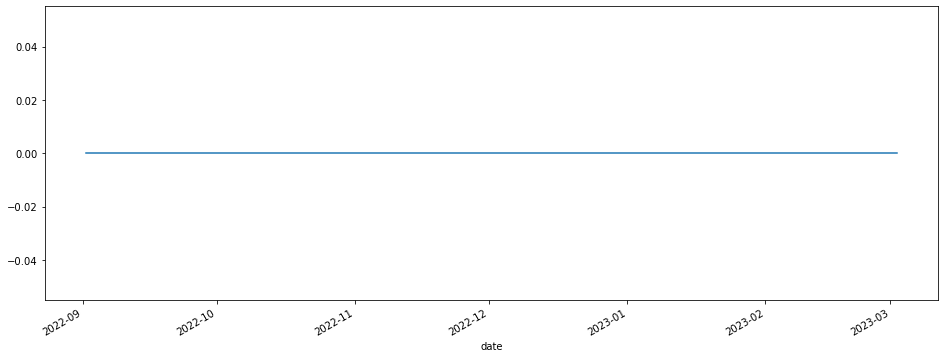

In [71]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
print(n)
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_SV_rank'].plot(figsize = (16,6))

In [72]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_SV_rank.isnull().sum()

0

#### 1-2.6 Traitement des valeurs manquantes pour Config_B_rank 

In [73]:
Avions.Config_B_rank.isnull().sum() # Changement de format de la piece B

992605

<AxesSubplot:xlabel='date'>

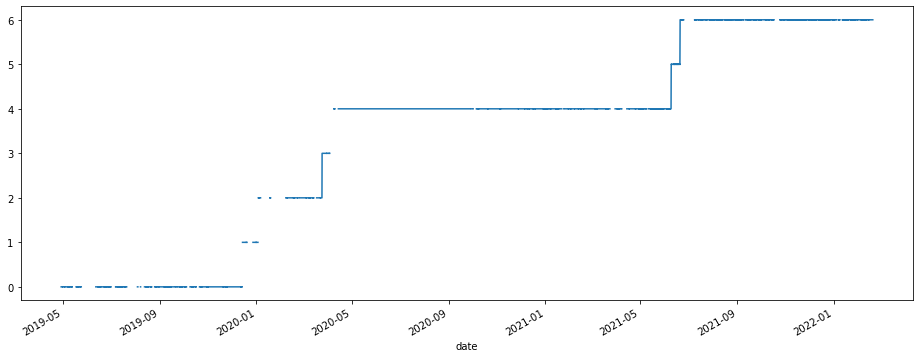

In [74]:
Avion1['Config_B_rank'].plot(figsize = (16,6))

In [75]:
Test=Avions.copy()

In [76]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_Config_B_rank=Avion_1.Config_B_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_Config_B_rank=Avion_2.Config_B_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_Config_B_rank=avion_i.Config_B_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_Config_B_rank=avion_i.Config_B_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

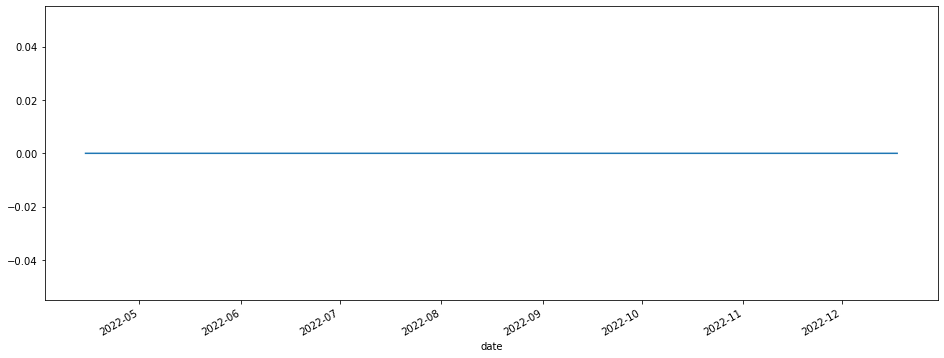

In [77]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_Config_B_rank'].plot(figsize = (16,6))

In [78]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_Config_B_rank.isnull().sum()

0

#### 1-2.7 Traitement des valeurs manquantes pour WW_rank 

In [79]:
Avions.WW_rank.isnull().sum() # Binaire : 1 si waterwash effectué

992605

<AxesSubplot:xlabel='date'>

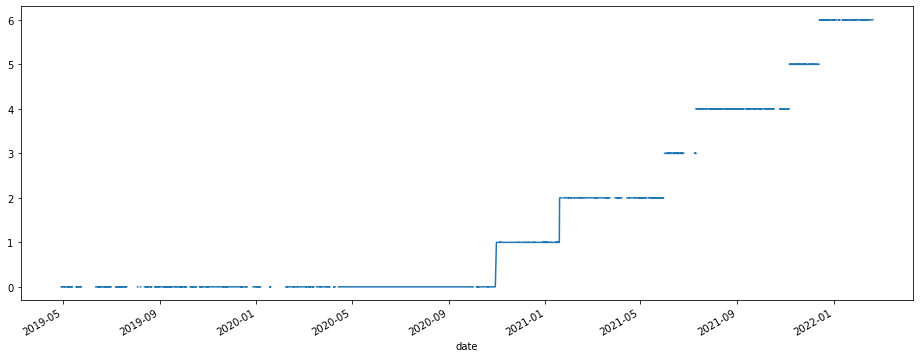

In [80]:
Avion1['WW_rank'].plot(figsize = (16,6))

In [83]:
Test=Avions.copy()

In [84]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_WW_rank=Avion_1.WW_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_WW_rank=Avion_2.WW_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_WW_rank=avion_i.WW_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_WW_rank=avion_i.WW_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

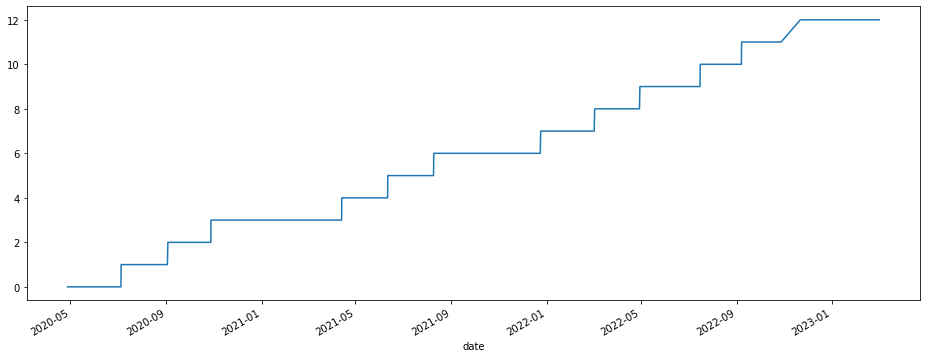

In [85]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_WW_rank'].plot(figsize = (16,6))

In [86]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_WW_rank.isnull().sum()

0

#### 1-2.8 Traitement des valeurs manquantes pour var_env_1

In [87]:
Avions.var_env_1.isnull().sum() # Variable environnement 1 

451389

<AxesSubplot:xlabel='date'>

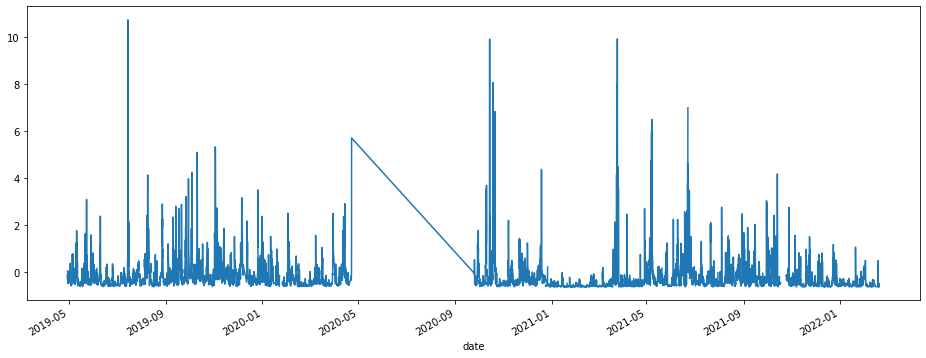

In [88]:
Avion1['var_env_1'].plot(figsize = (16,6))

In [89]:
Test=Avions.copy()

In [90]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_1=Avion_1.var_env_1.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_1=Avion_2.var_env_1.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.var_env_1.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.var_env_1.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

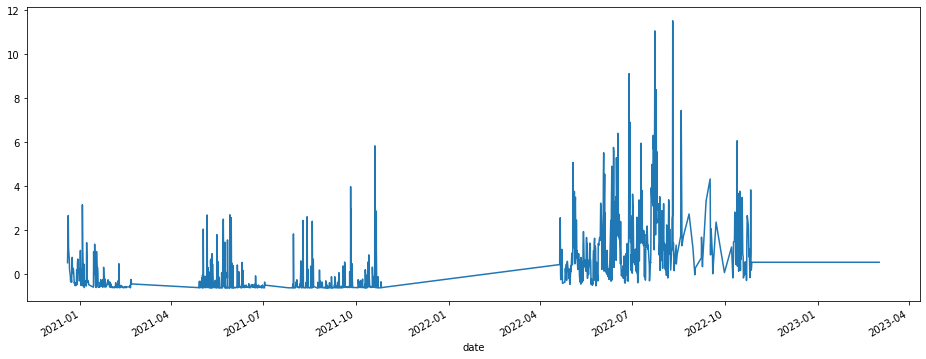

In [91]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_1'].plot(figsize = (16,6))

In [92]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_1.isnull().sum()

48876

In [246]:
Test= Avions.copy()

In [247]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_1=Avion_1.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_1=Avion_2.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [248]:
Avions.Interpolate_var_env_1.isnull().sum()

24963

In [249]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_18', 'ESN_81', 'ESN_94', 'ESN_135', 'ESN_154', 'ESN_156',
       'ESN_201', 'ESN_224', 'ESN_225', 'ESN_260', 'ESN_329', 'ESN_1124',
       'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198', 'ESN_1206',
       'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227', 'ESN_1230',
       'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276', 'ESN_1277',
       'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308', 'ESN_1315',
       'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332', 'ESN_1333',
       'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357', 'ESN_1358',
       'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363', 'ESN_1364',
       'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370', 'ESN_1371',
       'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375', 'ESN_1376',
       'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380', 'ESN_1381',
       'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385', 'ESN_1386',
       'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390', 'ESN_1391',
       'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395

In [250]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].nunique()

78

#### 1-2.9 Traitement des valeurs manquantes pour var_env_2 

In [93]:
Avions.var_env_2.isnull().sum() # Variable environnement 2 

258150

<AxesSubplot:xlabel='date'>

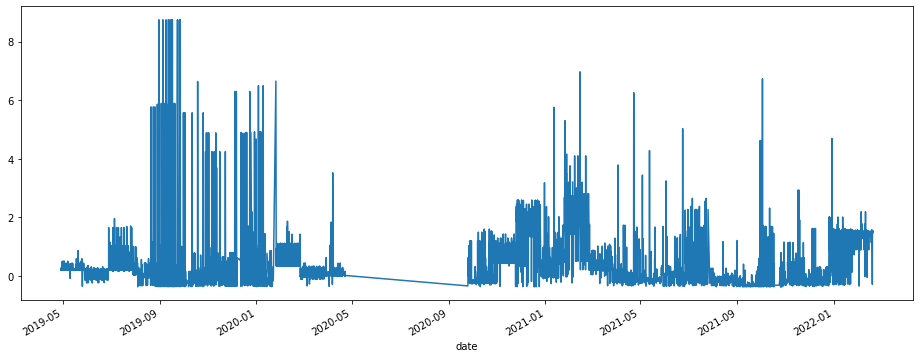

In [94]:
Avion1['var_env_2'].plot(figsize = (16,6))

In [95]:
Test=Avions.copy()

In [96]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_2=Avion_1.var_env_2.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_2=Avion_2.var_env_2.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.var_env_2.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.var_env_2.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

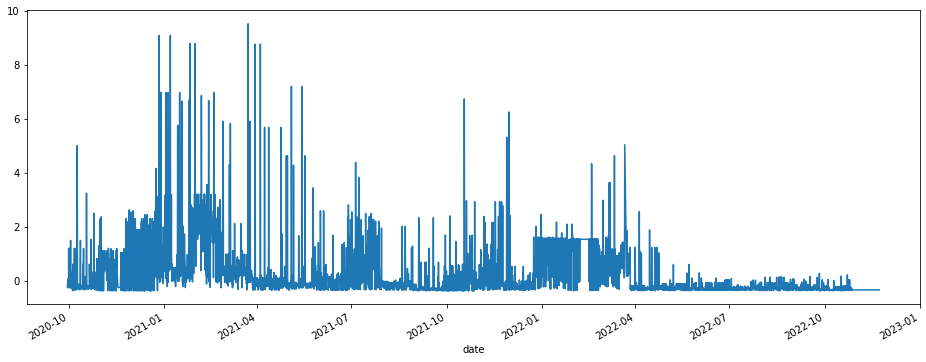

In [97]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_2'].plot(figsize = (16,6))

In [98]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_2.isnull().sum()

7872

In [242]:
Test = Avions.copy()

In [243]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_2=Avion_1.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_2=Avion_2.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [244]:
Avions.Interpolate_var_env_2.isnull().sum()

7744

In [245]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1222', 'ESN_1227', 'ESN_1230', 'ESN_1233',
       'ESN_1259', 'ESN_1261', 'ESN_1276', 'ESN_1277', 'ESN_1298',
       'ESN_1303', 'ESN_1306', 'ESN_1308', 'ESN_1315', 'ESN_1319',
       'ESN_1321', 'ESN_1323', 'ESN_1332', 'ESN_1333', 'ESN_1335',
       'ESN_1342', 'ESN_1356', 'ESN_1357', 'ESN_1358', 'ESN_1359',
       'ESN_1361', 'ESN_1362', 'ESN_1363', 'ESN_1364', 'ESN_1365',
       'ESN_1366', 'ESN_1367', 'ESN_1370', 'ESN_1371', 'ESN_1372',
       'ESN_1373', 'ESN_1374', 'ESN_1375', 'ESN_1376', 'ESN_1377',
       'ESN_1378', 'ESN_1379', 'ESN_1380', 'ESN_1381', 'ESN_1382',
       'ESN_1383', 'ESN_1384', 'ESN_1385', 'ESN_1386', 'ESN_1387',
       'ESN_1388', 'ESN_1389', 'ESN_1390', 'ESN_1391', 'ESN_1392',
       'ESN_1393', 'ESN_1394', 'ESN_1395', 'ESN_1396', 'ESN_1397'],
      dtype=object)

In [251]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].nunique()

65

#### 1-2.10 Traitement des valeurs manquantes pour var_env_3 

In [99]:
Avions.var_env_3.isnull().sum() # variable environnement 4 

625419

<AxesSubplot:xlabel='date'>

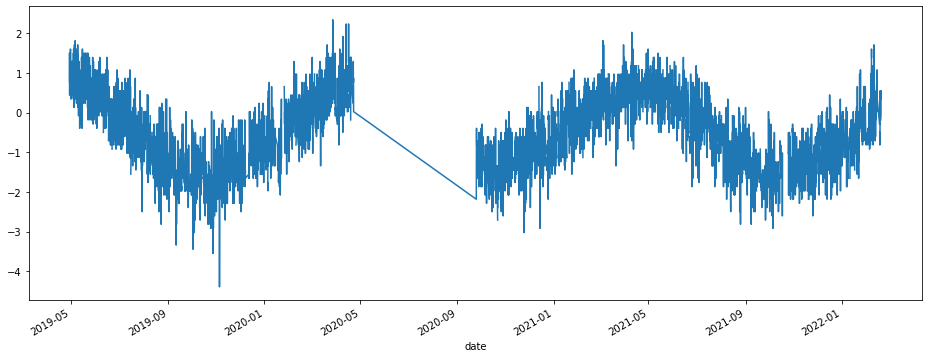

In [100]:
Avion1['var_env_3'].plot(figsize = (16,6))

In [101]:
Test=Avions.copy()

In [102]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_3=Avion_1.var_env_3.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_3=Avion_2.var_env_3.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.var_env_3.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.var_env_3.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

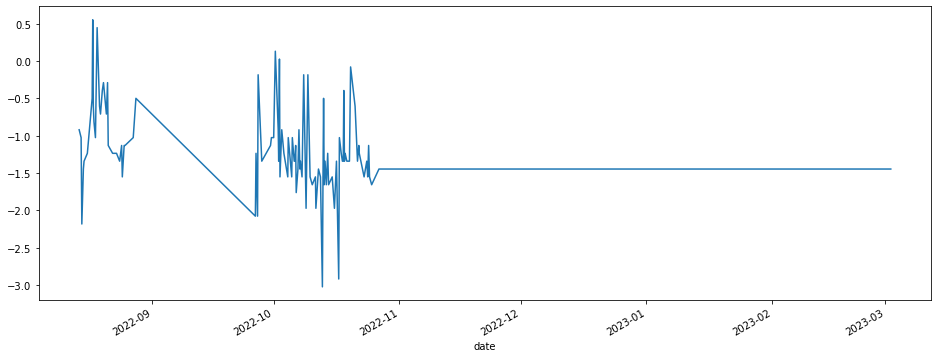

In [103]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_3'].plot(figsize = (16,6))

In [234]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_3.isnull().sum()

13193

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces valeurs

In [233]:
Test = Avions.copy()

In [235]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_3=Avion_1.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_3=Avion_2.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [239]:
Avions.Interpolate_var_env_3.isnull().sum()

8207

In [240]:
Avions[Avions['Interpolate_var_env_3'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227',
       'ESN_1230', 'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276',
       'ESN_1277', 'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308',
       'ESN_1315', 'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332',
       'ESN_1333', 'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357',
       'ESN_1358', 'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363',
       'ESN_1364', 'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370',
       'ESN_1371', 'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375',
       'ESN_1376', 'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380',
       'ESN_1381', 'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385',
       'ESN_1386', 'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390',
       'ESN_1391', 'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395',
       'ESN_1396', 'ESN_1397'], dtype=object)

In [241]:
Avions[Avions['Interpolate_var_env_3'].isnull()==True]['engine_serial_number'].nunique()

67

#### 1-2.11 Traitement des valeurs manquantes pour var_env_4 

In [105]:
Avions.var_env_4.isnull().sum() # Variable environnement 4, attention variable catégorielle

622175

<AxesSubplot:xlabel='date'>

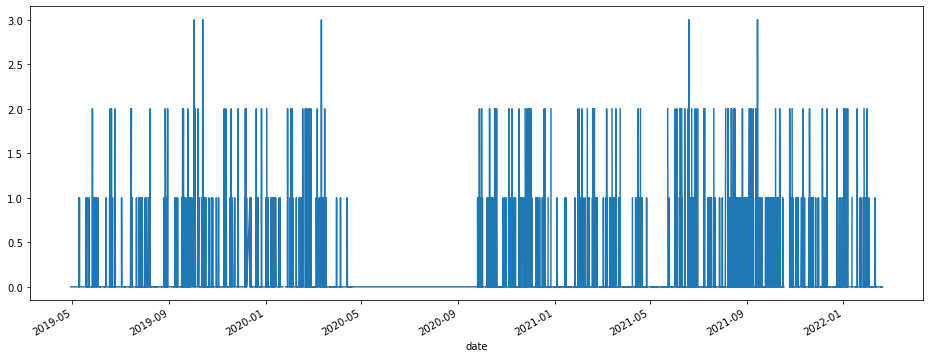

In [106]:
Avion1['var_env_4'].plot(figsize = (16,6))

In [107]:
Test=Avions.copy()

In [108]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_4=Avion_1.var_env_4.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_4=Avion_2.var_env_4.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.var_env_4.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.var_env_4.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

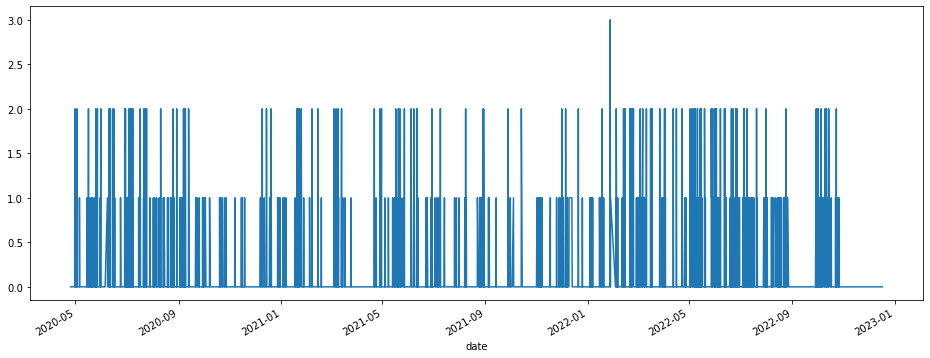

In [109]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_4'].plot(figsize = (16,6))

In [110]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_4.isnull().sum()

13193

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces valeurs

In [227]:
Test = Avions.copy()

In [229]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_4=Avion_1.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_4=Avion_2.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [230]:
Avions[Avions['Interpolate_var_env_4'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227',
       'ESN_1230', 'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276',
       'ESN_1277', 'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308',
       'ESN_1315', 'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332',
       'ESN_1333', 'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357',
       'ESN_1358', 'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363',
       'ESN_1364', 'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370',
       'ESN_1371', 'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375',
       'ESN_1376', 'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380',
       'ESN_1381', 'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385',
       'ESN_1386', 'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390',
       'ESN_1391', 'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395',
       'ESN_1396', 'ESN_1397'], dtype=object)

In [231]:
Avions.Interpolate_var_env_4.isnull().sum()

8207

In [232]:
Avions[Avions['Interpolate_var_env_4'].isnull()==True]['engine_serial_number'].nunique()

67

#### 1-2.12 Traitement des valeurs manquantes pour var_env_5 

In [111]:
safran.var_env_5.isnull().sum() # Variable environnement 5 

625530

<AxesSubplot:xlabel='date'>

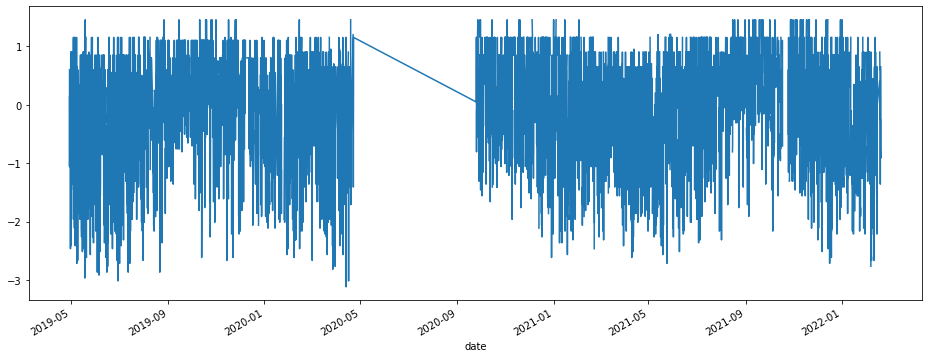

In [112]:
Avion1['var_env_5'].plot(figsize = (16,6))

In [113]:
Test=Avions.copy()

In [114]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_5=Avion_1.var_env_5.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_5=Avion_2.var_env_5.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_5=avion_i.var_env_5.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_5=avion_i.var_env_5.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

<AxesSubplot:xlabel='date'>

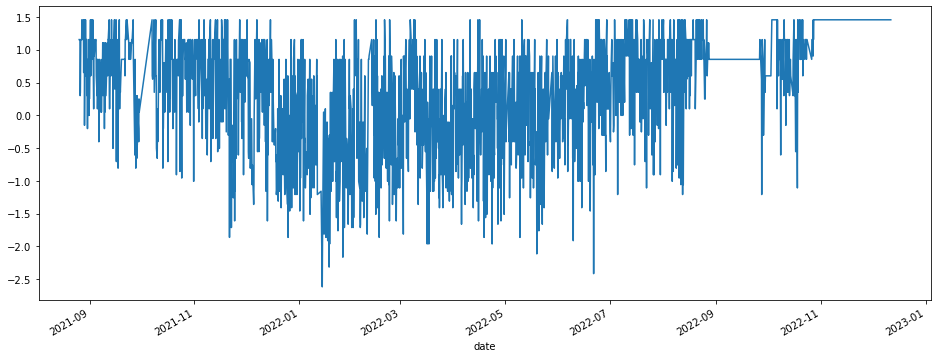

In [115]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_5'].plot(figsize = (16,6))

In [116]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_5.isnull().sum()

13193

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces dernières valeurs

In [190]:
Test = Avions.copy()

In [205]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_5=Avion_1.Interpolate_var_env_5.interpolate(method='time',limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_5=Avion_2.Interpolate_var_env_5.interpolate(method='time',limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_var_env_5=avion_i.Interpolate_var_env_5.interpolate(method='time', limit_direction='backward'))
        Avion_1=pd.concat( [Avion_1,avion])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    else :
        Avion_1=pd.concat( [Avion_1,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
        
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_var_env_5=avion_i.Interpolate_var_env_5.interpolate(method='time', limit_direction='backward'))
        Avion_2 = pd.concat( [Avion_2,avion])
        print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")
    else :
        Avion_2=pd.concat( [Avion_2,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
Avions=pd.concat([Avion_1,Avion_2])



Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_15  sur  la première

In [206]:
Avions.Interpolate_var_env_5.isnull().sum()

8207

In [209]:
Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227',
       'ESN_1230', 'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276',
       'ESN_1277', 'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308',
       'ESN_1315', 'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332',
       'ESN_1333', 'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357',
       'ESN_1358', 'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363',
       'ESN_1364', 'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370',
       'ESN_1371', 'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375',
       'ESN_1376', 'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380',
       'ESN_1381', 'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385',
       'ESN_1386', 'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390',
       'ESN_1391', 'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395',
       'ESN_1396', 'ESN_1397'], dtype=object)

In [225]:
Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].nunique()

67

67 moteurs différents sont encore concernés par les valeurs manquantes 

In [224]:
for i in Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique() :
    if Avions[Avions['engine_serial_number']==i]['Interpolate_var_env_5'].isnull().sum()==Avions[Avions['engine_serial_number']==i].shape[0] == False :
        print(i)

Pour les variables manquantes : il n'y a aucune donnée sur ces moteurs pour la variable environnement 5 

In [160]:
# Enregistrement de la base 
Avions.to_csv('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/pretraitement.csv')

# à revoir :
- interpolation de Interpolate_flight_leg_hours 
- egt_slope 
- var_env 1
- var_env 2
- var_env 3
- var_env 4
- var_env 5


In [37]:
path_Avions = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/pretraitement.csv'
Avions=pd.read_csv(path_Avions)

In [158]:
Avions.isnull().sum()

engine_serial_number                 0
engine_family                        0
engine_series                        0
cycles                               0
cycles_counter                       0
egt_margin                      994687
var_mot_1                       994689
flight_leg_hours                478815
event_rank                           0
egt_slope                        90397
SV_indicator                         0
SV_rank                         994687
Config_B_indicator                   0
Config_B_rank                   994687
WW_indicator                         0
WW_rank                         994687
config_A                             0
config_B                             0
var_env_1                       452108
var_env_2                       258552
var_env_3                       627044
var_env_4                       623799
var_env_5                       627155
Interpolate_egt_margin               0
Interpolate_var_mot_1                0
Interpolate_flight_leg_ho

In [39]:
Avions['date'] = pd.to_datetime(Avions['date'], format="%Y/%m/%d %H:%M:%S")

In [41]:
# On revoit pour la variable flight_leg_hours      
series = Avions['engine_serial_number'].unique()
series_1,series_2 = series[0: int(len(series)/2)], series[int(len(series)/2):int(len(series))]

calage_1 = series_1[0]
calage_2 = series_2[0]

In [42]:
Avions.index = Avions['date']
del Avions['date']

In [44]:
Test = Avions.copy()

In [51]:
Avions.Interpolate_flight_leg_hours.isnull().sum()

8497

Encore des valeurs manquantes : on va essayer le backward 

In [155]:
Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227',
       'ESN_1230', 'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276',
       'ESN_1277', 'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308',
       'ESN_1315', 'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332',
       'ESN_1333', 'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357',
       'ESN_1358', 'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363',
       'ESN_1364', 'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370',
       'ESN_1371', 'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375',
       'ESN_1376', 'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380',
       'ESN_1381', 'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385',
       'ESN_1386', 'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390',
       'ESN_1391', 'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395',
       'ESN_1396', 'ESN_1397'], dtype=object)

67 avions posent probleme 

In [159]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].nunique()

78

Un peu plus de problemes pour la variable env_1

In [69]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].nunique()

65

Un peu moins de problemes pour la variable env_2

In [96]:
set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique())

set()

La liste des avions problematique pour la variable flight_leg_hours est la même que pour les variables environement 5,4 et 3 

In [99]:
# Les deux avions qui posent problemes pour les variables environnement et durée de  sauf la 2 
set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].unique()) 

{'ESN_1211', 'ESN_1215'}

In [100]:
set(Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique())

{'ESN_135',
 'ESN_154',
 'ESN_156',
 'ESN_18',
 'ESN_201',
 'ESN_224',
 'ESN_225',
 'ESN_260',
 'ESN_329',
 'ESN_81',
 'ESN_94'}

In [154]:
Avions[Avions['engine_serial_number']=='ESN_1215']['Interpolate_flight_leg_hours'].isnull().sum()

225

In [157]:
Avions[Avions['engine_serial_number']=='ESN_1124']

,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,egt_slope,...,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_Config_B_rank,Interpolate_WW_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5
date,,,,,,,,,,,,,,,,,,,,,
2022-10-30 18:42:26,ESN_1124,Engine_family_1,Engine_series_1,566.4851,566,0.415837,0.717470,NaN,0,-0.016851,...,0.717470,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 09:26:05,ESN_1124,Engine_family_1,Engine_series_1,570.1247,567,0.691838,-0.947979,NaN,0,-0.016851,...,-0.947979,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 13:48:14,ESN_1124,Engine_family_1,Engine_series_1,571.2044,568,0.718738,-1.744150,NaN,0,-0.016851,...,-1.744150,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 22:33:11,ESN_1124,Engine_family_1,Engine_series_1,573.3666,569,0.669873,0.379992,NaN,0,-0.016851,...,0.379992,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-11-01 02:54:58,ESN_1124,Engine_family_1,Engine_series_1,574.4448,570,0.823662,0.327560,NaN,0,-0.016851,...,0.327560,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 20:28:59,ESN_1124,Engine_family_1,Engine_series_1,755.0000,752,0.697069,0.867914,NaN,0,-0.016851,...,0.867914,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2023-02-22 17:16:42,ESN_1124,Engine_family_1,Engine_series_1,755.0000,753,0.343151,0.311094,NaN,0,-0.016851,...,0.311094,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2023-02-22 20:34:40,ESN_1124,Engine_family_1,Engine_series_1,755.0000,754,0.281203,0.837450,NaN,0,-0.016851,...,0.837450,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


65 moteurs posent problemes pour toutes les variables environnement et la variable de durée de vol. 